In [276]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [277]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanAbsolutePercentageError as MAPE
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [278]:
def genreate_stock_data(stock_name,period):
    company = yf.Ticker(stock_name)
    df = company.history(period=period)
    
    #Sepreate the dates of the stock for further use if required
    date = (df.reset_index())['Date']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove data object from the database
    df = (df.reset_index()).drop('Date',axis=1)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the current trend of the current stock
    t = []
    for i in range(len(df)):
        if(df['Open'].iloc[i]-df['Close'].iloc[i]>0):
            t.append("DOWN")
        else:
            t.append("UP")
            
    df['Trend']=t
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the trend history of the stock
    th=[0]
    current_trend = df['Trend'].iloc[0]
    count = 0
    for i in range(1,len(df)):
        if(current_trend==df['Trend'].iloc[i]):
            count+=1
            th.append(count)
        else:
            count = 0
            th.append(count)
            current_trend = df['Trend'].iloc[i]
            
    df["Trend history"]=th
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the comparison to the change since last peak
    p=[]
    v=[]
    if(df['Trend'].iloc[0]=="DOWN"):
        peak = df['Open'].iloc[0]
        valley = df['Close'].iloc[0]
    else:
        valley = df['Open'].iloc[0]
        peak = df['Close'].iloc[0]

    for i in range(0,len(df)):

        p.append(peak-df['Close'].iloc[i])
        v.append(valley-df['Close'].iloc[i])

        if peak<df['Close'].iloc[i]:
            peak = df['Close'].iloc[i]
        if valley>df['Close'].iloc[i]:
            valley = df['Close'].iloc[i]
            
    df['Change since last peak']=p
    df['Change since last drop']=v
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the local change of daily stock
    c=[]
    cm=[]
    for i in range(0,len(df)):
        c.append(df['Open'].iloc[i]-df['Close'].iloc[i])
        cm.append(df['High'].iloc[i]-df['Low'].iloc[i])

    df['Local Change']=c
    df['Local range of stock price']=cm
    #-------------------------------------------------------------------------------------------------------------
    
    #Create dummy variable for the categorical variable
    df = pd.get_dummies(df,drop_first=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the label for the change from tommorow, the data that needs to be predicted
    next_day_change = df[1:]
    next_day_change = next_day_change['Local Change']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove The last column as the it is redundant
    df.drop(index=df.index[-1],axis=0,inplace=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Break the data into features and labels
    X = df
    y = next_day_change
    #-------------------------------------------------------------------------------------------------------------
    
    return(date,X,y)

In [279]:
def test_predictions(X_test,y_test,model):
    test_predictions = model.predict(X_test).flatten()
    #test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
    error = mean_absolute_percentage_error(y_test, test_predictions)
    print(error)
    
    plt.plot(test_predictions)
    plt.plot(y_test)
    plt.legend(['test','Actual'])

In [280]:
def df_to_X_y(df, window_size=5):
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [281]:
def create_model_conv(X,y,window = 5,path = ''):
    X_train, y_train = X[:int(len(X)*0.7)],y[:int(len(X)*0.7)]
    X_val, y_val = X[int(len(X)*0.7):int(len(X)*0.85)],y[int(len(X)*0.7):int(len(X)*0.85)]
    X_test, y_test = X[int(len(X)*0.85):],y[int(len(X)*0.85):]
    
    print(X.shape)
    
    model = Sequential()
    model.add(InputLayer((window, 1)))
    model.add(Conv1D(4096,2))
    model.add(Flatten())
    model.add(Dense(64, 'relu'))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp1 = ModelCheckpoint(path, save_best_only=True)
    model.compile(loss=MAPE(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

    model = load_model(path+'/')
    
    plt.plot(model.predict(X_train).flatten()[-100:])
    plt.plot(y_train[-100:])
    plt.legend(['train','Actual'])

    return(model)

In [284]:
model = load_model('MSFT'+'/')

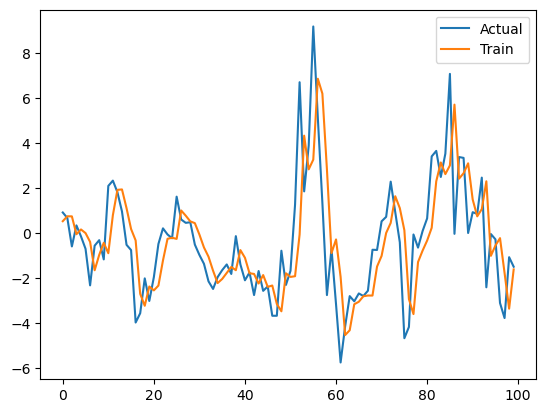

In [425]:
plt.plot((y_test[:len(y_test1)]-y_test1)[:100])
plt.plot((y_pred[:len(y_pred1)]-y_pred1)[:100])
plt.legend(['Actual','Train'])

In [426]:
date,X,y = genreate_stock_data('MSFT','max')

In [427]:
X_open = X['Open']
X_open

0         0.055121
1         0.060524
2         0.062686
3         0.063767
4         0.062145
           ...    
9389    334.339996
9390    337.480011
9391    351.320007
9392    339.309998
9393    336.369995
Name: Open, Length: 9394, dtype: float64

In [428]:
a = (X_open[-400:-390])
a2 = a

In [429]:
a2

8994    330.404793
8995    334.224001
8996    333.474574
8997    337.872476
8998    339.824953
8999    332.360298
9000    331.600988
9001    329.697808
9002    330.279618
9003    330.654309
Name: Open, dtype: float64

In [430]:
for i in range(5):
    y = model.predict([np.array([a2[-5:]])])
    a2 = np.append(a2,y.flatten()[0])

1/1 [==============================] - 0s 12ms/step


In [431]:
len(a2.flatten())

15

In [432]:
a = np.array(a)
a

array([330.40479308, 334.22400099, 333.47457364, 337.87247551,
       339.8249534 , 332.36029783, 331.60098805, 329.69780756,
       330.27961836, 330.65430913])

In [433]:
a2.flatten()

array([330.40479308, 334.22400099, 333.47457364, 337.87247551,
       339.8249534 , 332.36029783, 331.60098805, 329.69780756,
       330.27961836, 330.65430913, 330.60952759, 330.61572266,
       330.50585938, 330.47570801, 330.4581604 ])

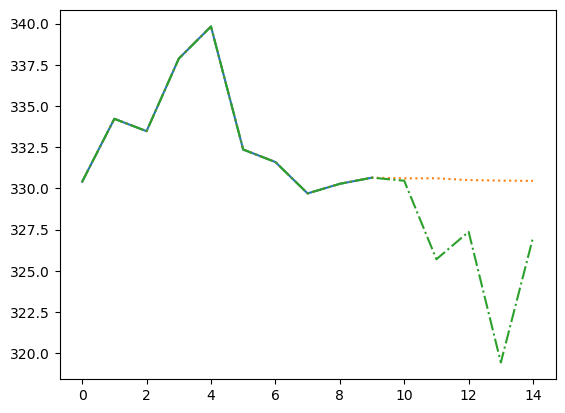

In [437]:
plt.plot(a)
plt.plot(a2,linestyle=':')
plt.plot(np.array(X_open[-400:-385]),linestyle='-.')